# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how Q-learning works, its limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \omega \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Q-learning with a table
In the first part, we will implement the Q-learning algorithm with a table. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```get_next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$. We will assume that $u$ can take only three possible values. Note that $\theta$ can take any value in $[0,2\pi)$ and that $\omega$ can take any value between $[-6,6]$. 

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for $\theta$ and 50 for $\omega$. Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.


1. Write a function ```get_cost(x,u)``` that returns the current cost $g(x,u)$ as a function of the current state and control.

2. What is the dimension of the Q-table that you will need to implement (as a numpy array)? Why?

3. How can you compute the optimal policy from the Q-table? And the optimal value function? Write a function ```get_policy_and_value_function(q_table)``` that computes both given a Q-table as an input.

4. Write a function ```q_learning(q_table)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should get as an input an initial Q-table  and return a learned Q-table of similar size. Use the function ```get_next_state``` from the pendulum package to generate the episode (do not discretize the real state of the pendulum!). During learning store the cost per episode to track learning progress.

5. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-4,0,4\}$? (use a learning rate of 0.1). Show the learning progress in a plot.

6. Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position? Plot the time evolution of $\theta$ and $\omega$. 

7. Plot the found policy and value function as 2D images (cf. below).

8. Answer questions 5 to 7 when using $u \in \{-5,0,5\}$. What quantitative differences do you see between the computed policies in 5. and 8.? Can you explain?

9. How is learning affected when changing $\epsilon$ and the learning rate? Why?

In [160]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pendulum

In [161]:
# we can get the integration step used in the simulation
print(f'dt is {pendulum.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {pendulum.NUMBER_STATES} and number of controls {pendulum.NUMBER_CONTROLS}')
print('the states are indexed as follows: theta, omega')

# we can get the maximum velocity of the pendulum (omega)
print(f'the max velocity is {pendulum.MAX_VELOCITY} rad/seconds')

dt is 0.1
number of states 2 and number of controls 1
the states are indexed as follows: theta, omega
the max velocity is 6.0 rad/seconds


In [162]:
# Plotting Functions

def show(t, x, u):
    # we can plot the results
    plt.figure()

    plt.subplot(2,1,1)
    plt.plot(t, x[0,:])
    plt.legend(['theta'])

    plt.subplot(2,1,2)
    plt.plot(t, x[1,:])
    plt.legend(['omega'])

    # we can also plot the control
    plt.figure()
    plt.plot(t[:-1], u.T)
    plt.legend(['u1'])
    plt.xlabel('Time [s]')


def show_value_policy(pendulum_object, q_table_star):
    value_function, policy = pendulum_object.get_policy_and_value_function(q_table_star)

    # we plot the value function
    plt.figure(figsize=[6,6])
    plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Value Function')

    # we plot the policy
    plt.figure(figsize=[6,6])
    plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Policy')

In [163]:
class QLearning:

    def __init__(self, u_list):
        self.u_list = u_list    #list of controls
        self.exploration_probability = 0.1      #epsilon

        self.max_episodes = 9000
        self.max_iterations_per_episode = 100 #t

        self.discount_factor = 0.99   #alpha
        self.learning_rate = 0.1 #gamma

        # we generate 50 equally spaced points for the angle and angular velocity
        self.discretized_angle = np.linspace(0, 2*np.pi, 50, endpoint=False)
        self.discretized_angular_velocity = np.linspace(-6, 6, 50)

        self.total_cost_per_episode = []
        self.combined_td_error_per_episode = []
    
    def get_cost(self, state, control):
        angle = state[0]
        angular_velocity = state[1]
        discount_factor = 0.99
        cost = ((angle - np.pi)*(angle - np.pi)) + (0.01*angular_velocity**2) + (0.0001*control**2)
  
        return cost

    def get_policy_and_value_function(self, q_table):

        value_function = np.zeros([50,50])

        policy = np.zeros([50,50])

        for angle_index in range(50):
            for angular_velocity_index in range(50):
                value_function[angle_index, angular_velocity_index] = q_table[angle_index, angular_velocity_index, :].min()
                index = q_table[angle_index, angular_velocity_index, :].argmin()
                policy[angle_index,angular_velocity_index] = self.u_list[index]

        return value_function, policy 

    
    def discretize_states(self, angle, angular_velocity):
        # now given an arbitrary continuous state angle
        arbitrary_angle = angle
        arbitrary_angular_velocity = angular_velocity

        # find the index of the closest element in the set of discretized states
        index_in_discretized_angle = np.argmin(np.abs(self.discretized_angle - arbitrary_angle))
        index_in_discretized_angular_velocity = np.argmin(np.abs(self.discretized_angular_velocity - arbitrary_angular_velocity))
        
        return index_in_discretized_angle, index_in_discretized_angular_velocity

    def show_loss_td_error(self):

        plt.figure(figsize=[10,10])

        time_steps = np.arange(start=0, stop=len(self.total_cost_per_episode), step=1)
        
        kernel_size = 100
        kernel = np.ones(kernel_size) / kernel_size

        plt.subplot(2,1,1)
        plt.plot(self.total_cost_per_episode)
        plt.legend(['cost'])
        moving_average_total_cost  = np.convolve(self.total_cost_per_episode, kernel, mode='same')
        plt.plot(moving_average_total_cost)
        plt.legend(['moving_average_cost'])

        plt.subplot(2,1,2)
        plt.plot(self.combined_td_error_per_episode)
        plt.legend(['TD_Error'])
        moving_average_total_td_error  = np.convolve(self.combined_td_error_per_episode, kernel, mode='same')
        plt.plot(moving_average_total_td_error)
        plt.legend(['moving_average_td_error'])   
        
    
    def q_learning(self, q_table):

        for episode in range(self.max_episodes):
                initial_state = np.array([0., 0.])  
                cost_per_iteration = 0
                td_error_per_iteration = 0

                for t in range(self.max_iterations_per_episode):
                    current_angle = initial_state[0]
                    current_angular_velocity = initial_state[1]

        
                    current_angle_index, current_angular_velocity_index = self.discretize_states(current_angle, current_angular_velocity)

                    if np.random.uniform() > self.exploration_probability:
                        control_index = q_table[current_angle_index, current_angular_velocity_index, :].argmin()
                        control = self.u_list[control_index]
                    else:
                        control_index = np.random.randint(0, len(self.u_list))
                        control = self.u_list[control_index]

                    cost = self.get_cost(initial_state, control)   #Calculating the cost
                    next_state = pendulum.get_next_state(initial_state, control)    # get next state
                    next_angle = next_state[0]
                    next_angular_velocity = next_state[1]

                    next_angle_index, next_angular_velocity_index = self.discretize_states(next_angle, next_angular_velocity)

                    min_q_value_for_next_state = q_table[next_angle_index, next_angular_velocity_index, :].min()
                    current_q_value_for_control = q_table[current_angle_index, current_angular_velocity_index, control_index]
                    td_error = cost + self.discount_factor*min_q_value_for_next_state - current_q_value_for_control  # Calculating TD error


                    q_table[current_angle_index, current_angular_velocity_index, control_index] = current_q_value_for_control + self.learning_rate*td_error

                    initial_state = next_state

                    cost_per_iteration += abs(cost)
                    td_error_per_iteration += abs(td_error)

                self.total_cost_per_episode.append(cost_per_iteration)
                self.combined_td_error_per_episode.append(td_error_per_iteration)

        return q_table


In [164]:
### Part A when Control (u) = [-4, 0, 4]

u_list1 = np.array([-4, 0, 4]) 

pendulum_case1 = QLearning(u_list=u_list1)

q_table = np.zeros([50,50,3])
q_table_star = pendulum_case1.q_learning(q_table)


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABsGG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAOv2WI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAAFHh7Xrjd2DW0nQAAAawAOkIsf/
b6Q43ABP2WD81iMv8WgH1qIriMT5itg+8zdUlji+M2fIsY/ZiVsmn82kDyT4LpjCkOVefZ/LVM31
A0tLZ2hiDXqcDcoEggKOtjY9CMYb+UlaCRVGKZr2OzpXHlaKZtCu3vYi2M0vuwvESUQDXuaEJ5Zs
DvPJdE4HxzWrAHAbqYXhn2nhFy2Zh1jvl9n08hwvr7UO02jXn0Owh50dZbkF56hR4wivXn4sj/qr
urfC7+UNk320iVM7NEnmHG6sJrpM/dh0nQ+5r39OQ6cHUFm0hB1kTY014bpkFYpfap7yuKrbFL3C
DF86Ek0m3piGtcybvONVtvleOBuQdzGdAa5YB52LAliqLd+bi6McnSKY2FoPfu5QadXS6EUfB0ep
YweeSRli/l0MDbC7pvc5D0pHCflfzYJd0GvBN+Tc9+CZCLt+T1EAFzZj+Wv7CTv80YchbrFmPXXf
OPncJiRo0fW0kYchLg+aBPifzdST1B0Xc02qNBl5GebBC7Xjcd2F8BVPqanIZrBIix+W1QWFnwBy
W3Wx1Gqz2Anf4VPbPqa1ddCsc1nlJ3X5fyxAF1wYVN5/1MHeAAsr2/d0zy/qjKaqmZVGbJfshUiZ
jj457wXGFgjQbte8AWB3EqjJLKuHKdcQqTPiWnn8KCxQhOrAEqxcFC2x9Lgp4fgNkhy4bx5elUr7
QnfIuAAAAwAVSAGOMciC85Akvp6KbYbgXMusVE5UI3xjdJYjtYGeFULlnFgp1TOvy2Liv14oliSH
mEmj/yvgJUGY99yvCzsX2EUUNvjN4UbbvlyPftQmopHUy003Mqk7QPWZ3SmA0TfcWAg/QGrZN2pR
4wfFcpFQQ9g15AGzmnqaYl5aiYlG5zM4qSHyv+TYJWpFT0SgtuJ7ccTUBknC2JVyjJWThzQcq3r6
yvnDAFGiX7WWtyXExF4tk1dP6jxSRwpzl+dtEoDAdg/mHu9/r4iUbHh6KSV51BePKjCw95Kx1XNx
Akp560e6GK1jPYLYwuDgwWNRUIQNhngQlgsHEu4H7hFglgH++nNtEl5/U1DNNTjtbqXnoYs5XRYI
pf2mhdxmava1PphDaLWdaOU9FYA50UdQgifwU0sZ+ZCJRQ9/1FoNrFzSpKzkk9X9SiFCVOVUDGvV
TXZ5qg/QfXTWlFlXApOei9rpZ7WF8Ao0D1Xh7dnxUrNSbTvq8eAEkmPNXZFUlyBtAepTW2f+LWdv
KOJknWTWXdYOwwmpCjTOFRmh5bgcwh3XdE2MQ1KEwwESzP9lzWUHQ+bT+GDtm67sIOvatFKxG33E
nYWxF2fxn2S/c3wsE4g5ypGTeMq1mJTVkwH/VRxPeYkms3Lj47vLUhs+6nCChpeEqhsl9YOuC3j1
f+d02iPrNpbiFn5tSrmXuUBozp9ZOyD+dlwLikLA+Qcij8UNg7A/77Lm8Sc75i3j+iIJCpdTEZSF
Eci2lemE6APAg7bd27WurXnxULK5klqdQPGJNEAdXmpiWhuqRoTPTXi9aJX6CsM3AuBkKQXSl3gE
uqvQjclfDnQsT97a2RbwLGmxYksJAD9Q8NgYjdJth85YtI7VtvHOKabcc7Bu0IC99SIi8xJW8AJ9
B96pT8oElSDksDEs5BPNLRFBrtObo2w+2yTaDsCwC/Kag6yjcyC4eOMPgvnKjj5B8aiyoBQfX+Tf
DCLDRENM5RKzJ+c8qIAUGx4942If3IJuVPVBPeOFzENQlbLeebMb+c1FkRaJ+D0wsdFq/IMDafXQ
LW7b55H5OlvE+mItM4tz9lO0eWDirWAnfPTizypEfYsU7jnK/MV9mJXSO0YiSYuz7JU1WzafrXxY
LmG8hrmwam/ual/5ZyZhJz7E/EqUxRdvv9/BBnCaJySL99ZyO6IfOYqXftHjtiaRpcvFFaYldbRG
h/DynrNR929LyzJq/RVc31PrhXtoyDeAy2HjqFbS/hGaEIZNTVQzkFFUK0hy7u2iHmhMFy7A+1X/
csfpJqGKzYGUd9SOyZnhJPj76rAyUX2x06hUl6miEkFVxAHUIgKx+GmEgPraWfAnxPwkxm+JazBq
1qDbdfYS4dSUJx2nQBiopDbR6Z8BGeyUVBN1/WR8J/y5YncJ+5l4ARH4ZRmt9D0TZiv1IMcv+POb
WXWi2aQQtLUw7m2dzNA1rLv5l75uD8n1Lgh5cnANBUZv84vD2PzgKyV4mXteVUSj6ZoN8vLzYfky
WR5bYwKL8GNTTW/eLPruxYVq5WwQvZIqKtSSm6w/eReNK+1dBCAPqQ/+d8t32UuNM4q61bnFFlMS
2GbG/WvE4N6y0nF1N3nGValHrHrukws9D+MZQS6pr4+M3l6Pr2h8DXF+cK4GQ5hTBIV6vFINVrvB
WOTTUyfOcYAPX5/B0vFTrPIg4td7UeAeUkQ/8ZmLoRXQ0HAZgUA67Ng/rE3zy7VURh/o0SLnhxUg
3vomk4QOzhUtJKHlFW2HjvVJuTOJblyd/Iy1zu6gmPhHhblqDABU4Oy8SvTdYNwUic9p3/BmQ0Hr
rAQ/NP9G2sxn8m+F2yGy2KJvXSVWCq/k4VvQqaIIOciLBm4RjWKFL9oPYwx8yfSuq2HxyndmUwbT
fK2IUbpN32Wa273XHXbAJ9flqhxo3dROqfaYOIB7+udUZvD0VhYA5LzTj/u9sglZjnjfJQk/QK1o
EkaFNfIN/v5VUHWGCpA0wOUaK+PVUqLlYpB9IfzehVZNAGTT3Uk9JZE7A6EIAofOxJ6JllBTjE3s
IOeO1oqp+2SlK665lv9LYm1G3GYv/+EZ0bXzbQqXoGlhF4m3eFUTyHaay1YyVfz5MuO/cxpnF3gH
NOaOyXPE/pUc6xTWSC9fe

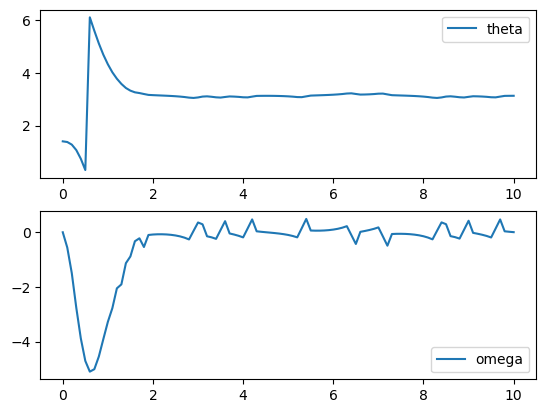

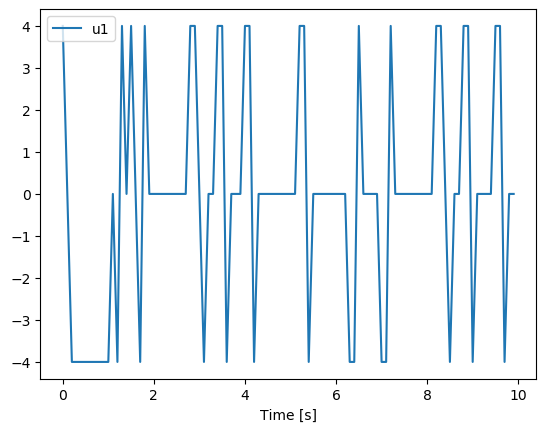

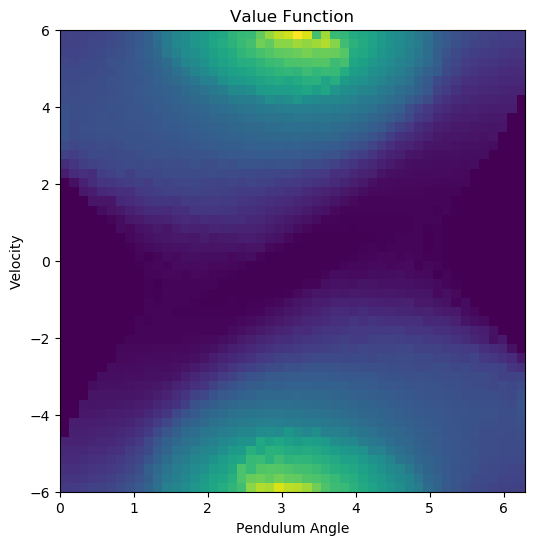

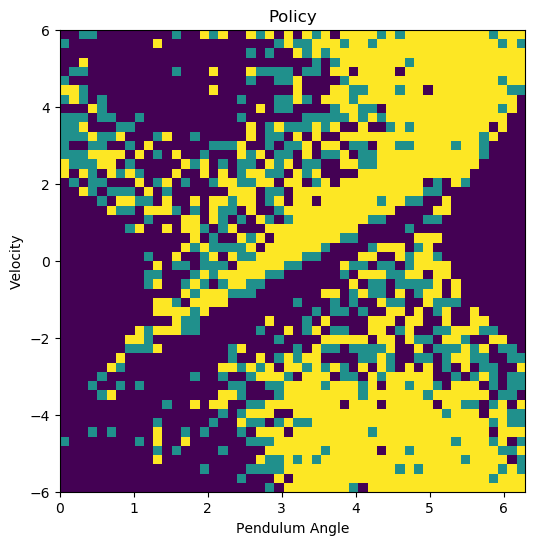

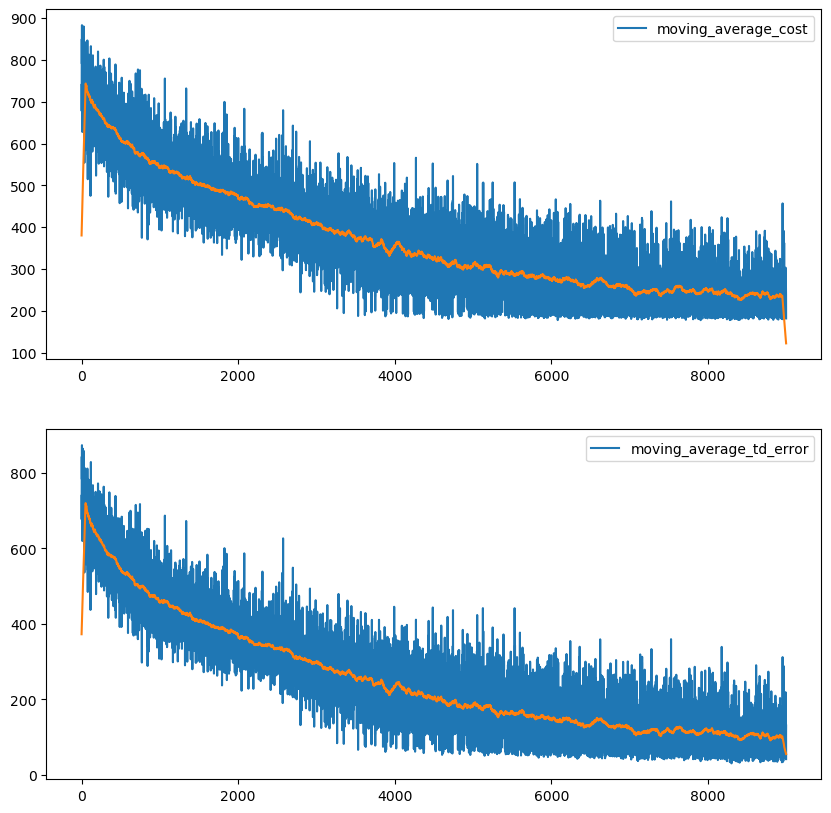

In [165]:
def dummy_controller(x):
    angle = x[0]
    angular_velocity = x[1]

    # get a discritize state space index for 
    angle_index, angular_velocity_index = pendulum_case1.discretize_states(angle, angular_velocity)

    u_idx = q_table_star[angle_index, angular_velocity_index, :].argmin()
    u = pendulum_case1.u_list[u_idx]

    return u

# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([1.4,0.])
t, x, u = pendulum.simulate(x0, dummy_controller, T)

# now we can also create an animation
pendulum.animate_robot(x)

show(t, x, u)
show_value_policy(pendulum_object=pendulum_case1, q_table_star=q_table_star)
pendulum_case1.show_loss_td_error()

In [166]:
### Part B when Control (u) = [-5, 0, 5]

control_list2 = np.array([-5, 0, 5]) 

pendulum_case2 = QLearning(u_list=control_list2)

q_table = np.zeros([50,50,3])
q_table_star = pendulum_case2.q_learning(q_table)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABxNG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAOy2WI
hAA///73aJ8Cm1pDeoDklcUl20+B/6tncHyP6QMAAAMAAAMAABW3pGWGQnQv8mIAAAV8ALIGZJnp
cUkTgA8wx7J03TT8KodCGFz3ILMf1XToD7aSZN8Zs9uaEA9jcSCQE44zxR7Qj2Eksq8+z+WqZvqh
qAmjtIUGvU4G5QJBAUbbGyaCYw38oY0EiqMUzXsdmysQKkUzaDNvexFsZpfdheEoKgGvZW8G2fPt
zPJdE33RzWsoHAbqHv7LUb1Fy2Yp1iQ19n08hwvr7IO0kg4fVQgC6P3/C57Zm0TDpNKoFwovx46y
wGgxxfs9fMlSyts++IhsON1YTXSZ+7DpOh9xNtWwLsYWvRnBU9gf4A7JwBQWOYAYmT3lcVW2KXuE
GLv0JJpNvTENa5k3ecOrbfK8cDcg1mM6A1ywDzsWBLtHFqEHFz46aeIgVgX6Pdyg4Kul0Io+Do9S
xg88kjK9/LoYG2F3VfdVQaKRk7nyknpJNmZCjrW6uCq/8zPb74qIALmzH8tf2Eg/4nPmesrFmbAh
/Qv2W9iRo0fW0kYXJDEI2nnzn6v5VjQdF3NNqjQZeJvRh6NvWJsuf9oVT6mpyGawSIsfltRWBZ71
Tlt1sggt2/YAOvhY9s+prV10KxzWeUmVfl/K0iXfBhU3n/Uwd4ACyvb+3TPL+qMpqqZlTafRoNQc
WzJWdJIBfYWCNBu17wBYHcSpsksoE0+h02cw0yVE5KzvWpIKutphXquCj3l7hrU8HKtwyuZcKfO3
lfJSpptkAAADAAhRALMYJXvzkCS+nzZysfy/0R0hxRRcvjG6Swje2Jc2G5Qxeh2iGTNAmLiv14ol
iSHmEmj/yvgJUGY2FyqCzsX2EUUNvjN4TbDvlyPftQmopHQy003Mqk7QPWZ3Sl+cTfcWAg/QGrZN
2Z54wfFcpFQQ9go5QGzmnqaYl5aiWMV5V84qSHyv+TYZYpFT0SgtuJ7cwTUBknC2JVyi3WThzQcq
3r6yvnDAFGeX+YDBxJExF4tk1dOQIw4U5y/O2iUBgOwfzEFe/18xKCrOq1IFmSkPHlRhYe8ltivc
yT1FR2tZ+ibayPsLtJs6aiFjXLEEDYZ4EJYLB2L0Bu4RUTZim6xLiUo7/RE9Cb7x3VXca4afwhqa
2b//3igVGVhmF9MVQD5+opH32UjHOV7pBr08Z8+v8Rz4Sux/Txv8snScvhjkjOPQKeMetWrVwai8
aUCqY4SiwQkdCa8WDsXoqebhIxxsvIcypD1xEmxjt5ir9P9AudMVgdr2fVLXxwjb1c5erIG0Oimg
nLaZquvFrO3lHEyTrJrLusHYYEUhRpwBVRoeW4HMId13RNQpKUqN8BEsz/ZijBy0Pm0/hg7Zuu7C
EN2rRSsRt9xJ2FsRSOcu9mxKgfq///08tPMh9I0smzZTwhJTB65dfYOBZB4MHd5akNn3U4LJul4S
qGyX1g64LeOXfqxy+09ooyJSKBcC7l36f//2IXdQK7MN9fy2itTsuSyErr7B47bROWJ6oIvlL/tF
1QHGNpr0QmHUruoHe3YVChh1NIc9jXUvtv+pZEyXMkhjh/6iDOnFQRCjyb1/qJ2YRETK5qhAkiyv
0FYZuBcDIGTW3md08E7w8RuSvhzoUi+7QOueazYrg4spHAMByopAg2M+xqw1NXT6YcNcADBqECIg
yz4L31NXqzElbwAnwr2/OER3X0BmbwGRZyCeaWiKDXac3O/94oH+VK5ujlIi1R0lrcp+2TT1NJD4
NiSPt7xxBj7mQdeozeeljbLXsMJxEjEYYBqrKc9zS12IkcoTLTlIdul7sKu8snrQFJqfLV7pD/Y0
BKAuqryge4MUPKfCx0Wr85J9EM0EV52ysBvyCj3bVVFjMh8OLjmJVss7xoeQmHUM8qRH1GmER4aa
OHmMxK6GUiYBMuPaCDqqbdEfWvcpcmbyGua2zb+5qX/lnI0pG1yefDCKti7flh3NiHy3k6pQ8XU3
tKj15zFTpQlF1R0y0WzxRVE/55azbuQ50IxNq/b2REMmr9FVbfU+tSFyK1emlAvgpIS2IzQaZRj5
B4L0MHVxJ2c4TZz+nEyp55Dz/t/7lj8xtbErNfvifhXoIhYS6APxpjbfm3bC4gmZ2V9EJIKXy+L/
VKLORHTOKrpO6BOcQja4Md+u/rL449dvvhuO7NmvJXv1bA0leAlfCCtuzE3gkkyKH+f81hpCYgKB
OlNK0JHbJuqG8StaV8lbhwH0x36tmclBiN3Agomk1LayX6vsw7R1TjHAs5xBZrQS+ciLMnlpxoS2
qmiYbxbbAIkCvgb9qvfM7rGqJM3475FW2xKkNoIJXYsd8jBgSfMclTJXCsnhKi09aciO3kK/5EFO
Q5nTLmQWmou1igbFDaqJl05sw+qkihrG0YeVE4XjmVXdB+vCxIdW7qiitMUflCx7iY0IEzJI5fyR
Ol61vIGhMDR4FgOH+PohsJ7ulTSdW+dju6Auk/9N+QqiJwporQzg+dSGU/8OCfPa6hcyU3X6/W4E
kggJGbO1unJXany7n7aQ6Gdq2XxBO06q52/HV7Eb0y4XMZ5kx58FQ9e+TMetgEluXMRcjMJK04jh
+NM2OvAzNpffLwSWkyid9xeLAZG/Y/wbazGfuqaDPpkIT51fc69VSkP6YW87LNKdB3s4x1Y0gXIc
kHWKp8kZvvtTgnrVNpW0J1/XpXARWVf+jRrIJhG70DUzE+xzLVDjRu6hUd0iue83X651RneHorCw
ByXmq1rp3848Gl/QYiNadArWgSRoVOAWH+/lVQdYYKkDTCdK8z49VSouVikH0g6QvcJ914QYSrDa
GjVjhF0uuW252JPUcHjFSpfc5Ev0S2FgOJOUpXXXMt/pYtHeW4zF//wjDcnQrutKxdpyUiNxIYVR
PIdprLV7Dsfpe2R37mNM4

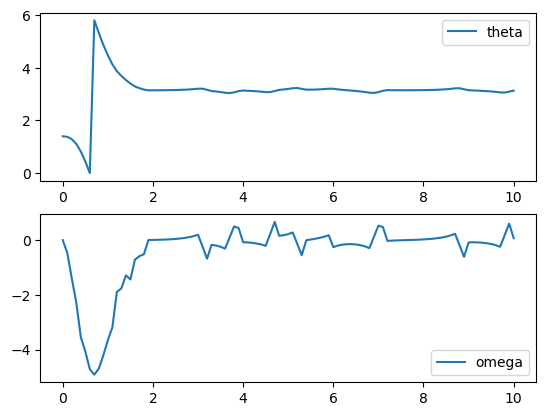

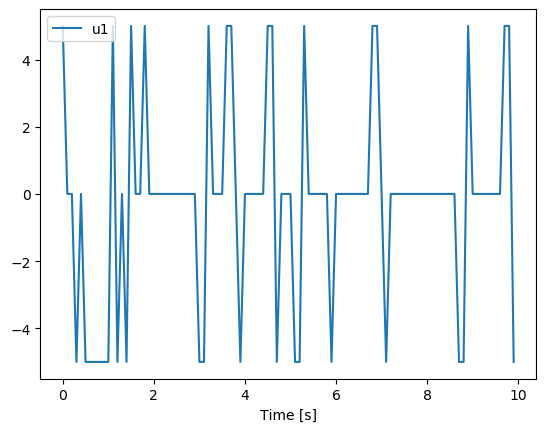

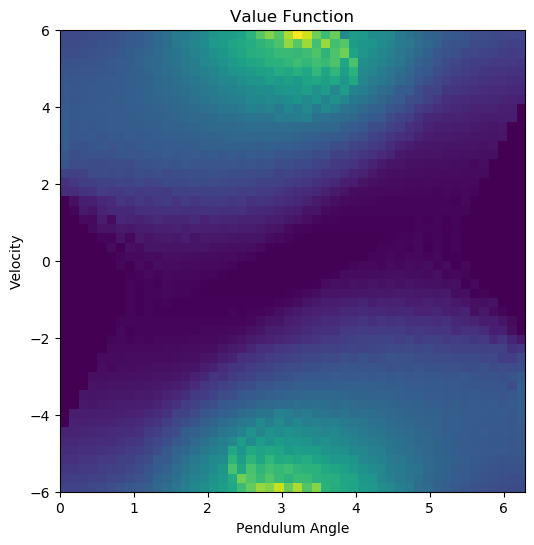

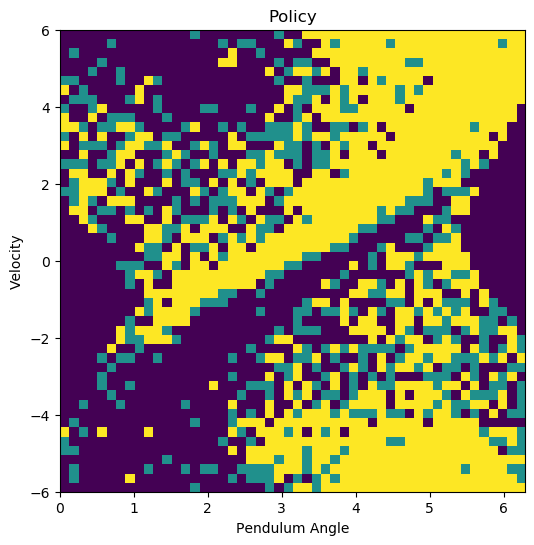

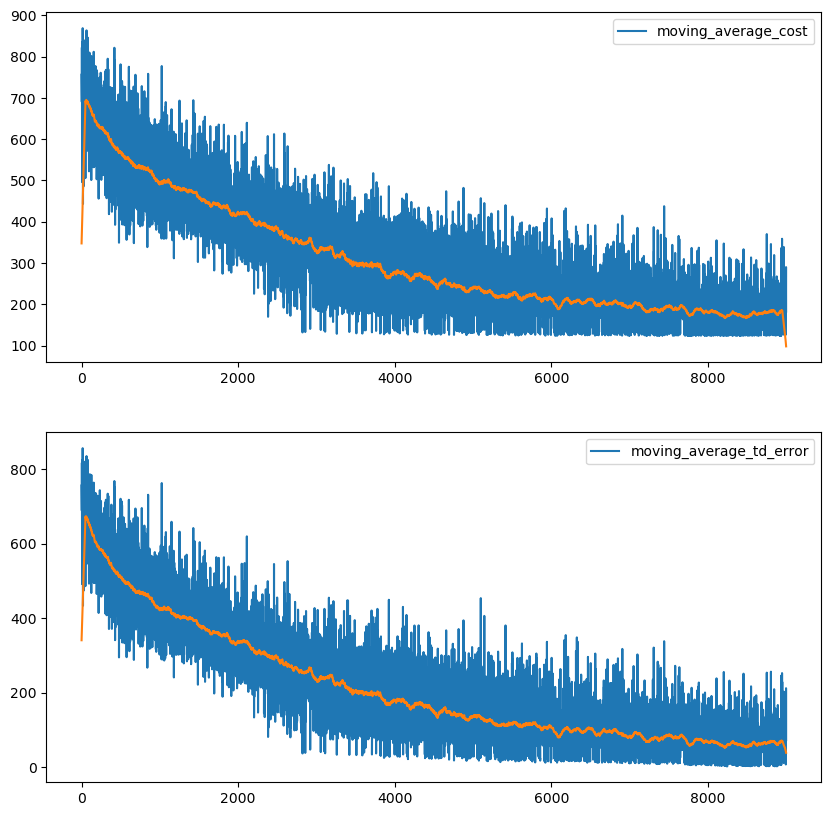

In [167]:
def dummy_controller(x):
    angle = x[0]
    angular_velocity = x[1]

    # get a discritize state space index for 
    angle_index, angular_velocity_index = pendulum_case2.discretize_states(angle, angular_velocity)

    u_idx = q_table_star[angle_index, angular_velocity_index, :].argmin()
    u = pendulum_case2.u_list[u_idx]

    return u

# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([1.4,0.])
t, x, u = pendulum.simulate(x0, dummy_controller, T)

# now we can also create an animation
pendulum.animate_robot(x)

show(t, x, u)
show_value_policy(pendulum_object=pendulum_case1, q_table_star=q_table_star)
pendulum_case2.show_loss_td_error()